# <span style="color:red">6. Solution</span>

## Portfolio Management
### MLP Training

#### January 2025

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Timing

### 1.1. 

Use the data found in `mkt_timing_data.xlsx`.

Construct an investment strategy where you go long `SPY` (100%) at any time where the earnings-price ratio (E/P) is above `4.5%`. When the ratio is below this level, you are long Tbills (100%) and earning `US3M`.

Report the following statsitics in a table where the first column is `SPY` and the second column is your strategy,
* mean
* vol
* Sharpe

Also report the correlation between your strategy and `SPY`.

### 1.2.

Re-do the previous problem, but instead of setting the weights to 100% and 0%, set the weights to be...

$$w_t = -0.8 + 30x_t$$

### 1.3.

Run a regression to understand the relationship between `E/P` at time $t$ and the subsequent return in `SPY`. That is, estimate $\beta$ in 

$$r_{SPY,t+1} = \alpha + \beta x_t + \epsilon_{t+1}$$

where $x$ is the E/P ratio.

Report the estimated $\beta$ and r-squared. What do you conclude about the statistical relationship?

***

# <span style="color:red">1.</span>

### <span style="color:red">Data</span>

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

In [3]:
import sys
sys.path.insert(0, '../cmds')
from portfolio import performanceMetrics, tailMetrics, get_ols_metrics
#from risk import *
from porttools import heatmap_vector

In [4]:
FILE = '../data/mkt_timing_data.xlsx'

SHEET_SPY = 'returns (total)'
SHEET_SIGS = 'signals'
SHEET_RF = 'risk-free rate'

FREQ = 12

spy_raw = pd.read_excel(FILE,sheet_name=SHEET_SPY).rename(columns={'Unnamed: 0':'date'}).set_index('date')
sigs_raw = pd.read_excel(FILE,sheet_name=SHEET_SIGS).rename(columns={'Unnamed: 0':'date'}).set_index('date')
rf_raw = pd.read_excel(FILE,sheet_name=SHEET_RF).rename(columns={'Unnamed: 0':'date'}).set_index('date')

In [5]:
common_index = spy_raw.index.intersection(sigs_raw.index).intersection(rf_raw.index)

spy = spy_raw.loc[common_index]
sigs = sigs_raw.loc[common_index]
rf = rf_raw.loc[common_index]


### <span style="color:red">1.1., 1.2.</span>

In [6]:
THRESH = .045

rets = pd.DataFrame(dtype=float,index=spy.index,columns=['passive','threshold','linear','regression'])
wts = pd.DataFrame(dtype=float,index=sigs.index,columns = rets.columns)

wts['passive'] = 1
wts['threshold'] = (sigs['EP'] / 100 > THRESH) * 1
wts['linear'] = -.8 + 30 * sigs['EP'] / 100

wts = wts.shift()

### <span style="color:red">1.3.</span>

In [7]:
model = LinearRegression(fit_intercept=True)
regdata = pd.concat([spy,sigs['EP'].shift()],axis=1).dropna()

X = regdata[['EP']]
y = regdata['SPY']

model.fit(X,y)
table_regression = pd.DataFrame(index=['alpha','beta','r-squred'],columns=['EP'],data=[model.intercept_, model.coef_[0], model.score(X,y)])

table_regression

,EP
alpha,-0.0062
beta,0.0033
r-squred,0.0087


### <span style="color:red">Report return metrics for 1.1, 1.2, 1.3.</span>

#### Note:
`1.3` did not ask you to implement the signal suggested by the regression. 

Nevertheless, it is implemented below as
$$ w_t = 75 \hat{r}_t$$

The forecast from the regression is linear, as you did in `1.2`. The regression estimates simply try to improve on the specification of the linear strategy. Below you see that it is almost an identical strategy. (Correlation to the linear strategy of `1.2` is near 1.)

Remember that the regression was estimated on the full sample, so using it as a signal in the same sample is a biased, "in-sample" result.

In [8]:
rhat = model.intercept_ + model.coef_[0] * regdata['EP']

# wts are already shifted here, given how the regression was set up
wts['regression'] = 75 * rhat


In [9]:
for col in wts:
    rets[col] = spy.squeeze() * wts[col] + rf.squeeze() * (1-wts[col])

In [10]:
performanceMetrics(rets,annualization=FREQ)

,Mean,Vol,Sharpe,Min,Max
passive,0.1032,0.1493,0.6914,-0.1652,0.1270
threshold,0.0911,0.0931,0.9782,-0.0924,0.1270
linear,0.0855,0.0909,0.9411,-0.0955,0.1553
regression,0.0890,0.0964,0.9231,-0.0907,0.1468


In [11]:
rets.corr()

,passive,threshold,linear,regression
passive,1.0000,0.6176,0.7303,0.8518
threshold,0.6176,1.0000,0.8650,0.8436
linear,0.7303,0.8650,1.0000,0.9799
regression,0.8518,0.8436,0.9799,1.0000


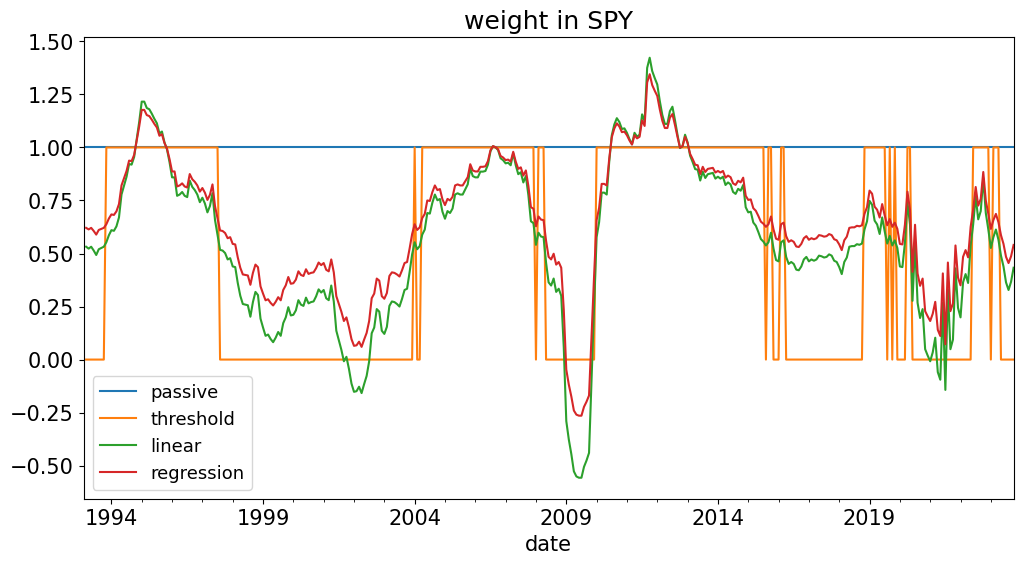

In [12]:
wts.plot()
plt.title('weight in SPY')
plt.show()

<Axes: xlabel='date'>

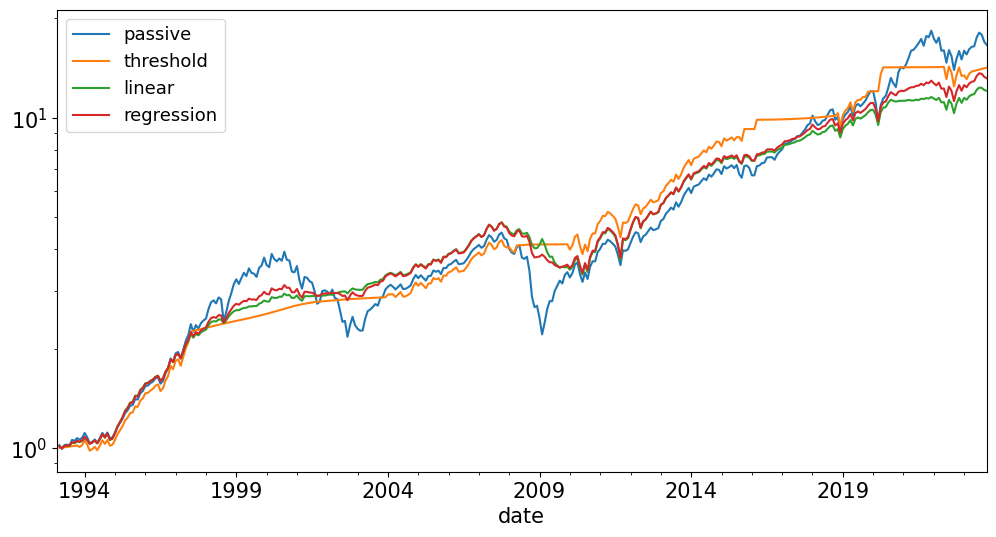

In [14]:
(rets+1).cumprod().plot(logy=True)